## Set-up environment

In [ ]:
!pip install uv

# Latests transformers + vision libraries
!uv pip install --system -q -U transformers
!uv pip install --system -q -U timm torchvision Pillow numpy==1.*

# For training
!uv pip install --system -q -U datasets accelerate
!uv pip install --system -q -U "albumentations==1.4.6" torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 33.9 MB/s eta 0:00:00


In [ ]:
!pip install numpy==2.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
cudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 20.0.0 which is incompatible.


In [ ]:
checkpoint = "PekingU/rtdetr_v2_r18vd"
image_size = 480

## Load dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("PodYapolsky/LogoDet-3K")

if "validation" not in dataset:
    split = dataset["train"].train_test_split(0.15, seed=1337)
    dataset["train"] = split["train"]
    dataset["validation"] = split["test"]

dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/91.0k [00:00<?, ?B/s]

train-00000-of-00006.parquet:   0%|          | 0.00/415M [00:00<?, ?B/s]

train-00001-of-00006.parquet:   0%|          | 0.00/416M [00:00<?, ?B/s]

train-00002-of-00006.parquet:   0%|          | 0.00/415M [00:00<?, ?B/s]

train-00003-of-00006.parquet:   0%|          | 0.00/414M [00:00<?, ?B/s]

train-00004-of-00006.parquet:   0%|          | 0.00/415M [00:00<?, ?B/s]

train-00005-of-00006.parquet:   0%|          | 0.00/416M [00:00<?, ?B/s]

test-00000-of-00002.parquet:   0%|          | 0.00/313M [00:00<?, ?B/s]

test-00001-of-00002.parquet:   0%|          | 0.00/312M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/126923 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/31731 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_path', 'industry_name', 'company_name', 'bbox'],
        num_rows: 107884
    })
    test: Dataset({
        features: ['image_path', 'industry_name', 'company_name', 'bbox'],
        num_rows: 31731
    })
    validation: Dataset({
        features: ['image_path', 'industry_name', 'company_name', 'bbox'],
        num_rows: 19039
    })
})

Examples from dataset

In [ ]:
dataset["test"][0]

{'image_path': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=505x375>,
 'industry_name': 'Transportation',
 'company_name': 2447,
 'bbox': [101, 122, 464, 207]}

## Preprocess the data

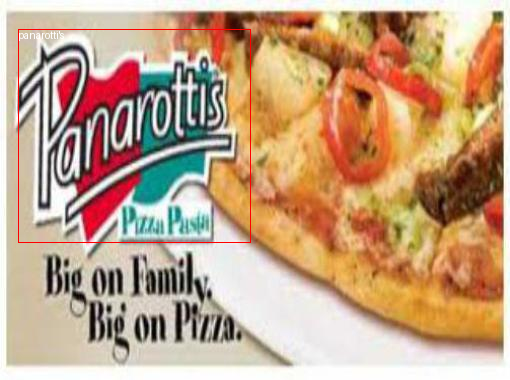

In [ ]:
import numpy as np
from PIL import Image, ImageDraw

# Create mappings for company_name
company2id = {
    name: idx
    for idx, name in enumerate(dataset["train"].features["company_name"].names)
}
id2company = {v: k for k, v in company2id.items()}

id2label = {0: "logo"}
label2id = {"logo": 0}

# Load image and annotations
image = dataset["train"][0]["image_path"]  # Use 'image_path' as per the provided dictionary
annotations = dataset["train"][0]

# Draw bounding box and label
draw = ImageDraw.Draw(image)
box = annotations["bbox"]
company_id = annotations["company_name"]  # Get company_name (2447)
label = id2company[company_id]  # Convert company_id to company_name using id2company
x, y, w, h = tuple(box)
draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
draw.text((x, y), str(label), fill="white")  # Use str(label) to ensure text compatibility

image

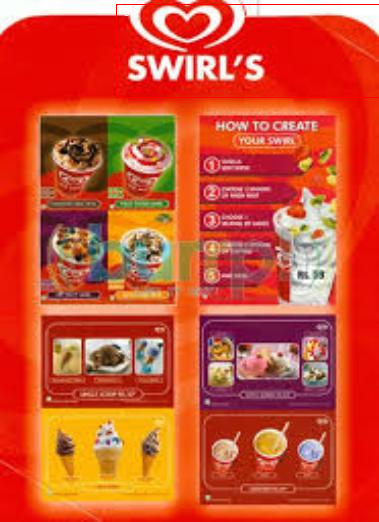

In [ ]:
import numpy as np
from PIL import Image, ImageDraw

# Define a single class for all logos
label = "logo"  # Single class label for all logos

# Load image and annotations
image = dataset["train"][132]["image_path"]  # Use 'image_path' from dataset
annotations = dataset["train"][132]

# Draw bounding box and label
draw = ImageDraw.Draw(image)
box = annotations["bbox"]
x, y, w, h = tuple(box)  # Bounding box format: [x, y, w, h]
draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
draw.text((x, y), label, fill="white")  # Label all bounding boxes as "logo"

image

Instantiate the image processor for the same checkpoint as the model

In [ ]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(
    checkpoint,
    do_resize=True,
    size={"width": image_size, "height": image_size},
    use_fast=True,
)

preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

Before passing the images to the `image_processor`, applying two preprocessing transformations to the dataset:
- Augmenting images
- Reformatting annotations to meet RT-DETRv2 expectations


In [ ]:
import albumentations as A

# Define single class for logos
label = "logo"
class_id = 0  # Single class ID for "logo"
# Safe cropping that adapts to image size
train_augmentation_and_transform = A.Compose(
    [
        # Scale augmentations first
        A.OneOf([
            A.RandomScale(scale_limit=(-0.7, 0.8), p=1.0),
            A.Resize(height=640, width=640, p=0.3),
        ], p=0.7),

        # Safe cropping - pad first, then crop
        A.OneOf([
            A.Compose([
                A.PadIfNeeded(min_height=500, min_width=500, border_mode=0, p=1.0),  # Pad to minimum size
                A.RandomCrop(height=500, width=500, p=1.0),
            ], p=1.0),
            A.Compose([
                A.PadIfNeeded(min_height=400, min_width=400, border_mode=0, p=1.0),
                A.RandomCrop(height=400, width=400, p=1.0),
            ], p=1.0),
            A.RandomResizedCrop(height=640, width=640, scale=(0.3, 1.0), ratio=(0.8, 1.2), p=1.0),
        ], p=0.4),

        # augmentations
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="coco",
        label_fields=["category"],
        clip=True,
        min_area=25,
        min_width=1,
        min_height=1,
    ),
)
# Define validation transform (no augmentation, just clipping)
validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="coco",
        label_fields=["category"],
        clip=True,
        min_area=1,
        min_width=1,
        min_height=1,
    ),
)

Visualize some augmented images to make sure images look natural and annotations are correct

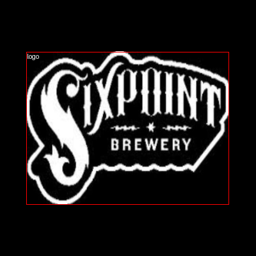

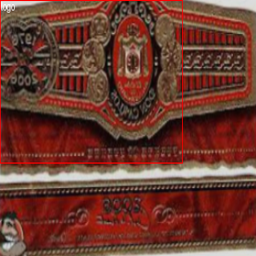

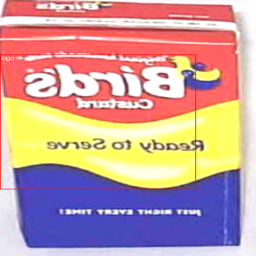

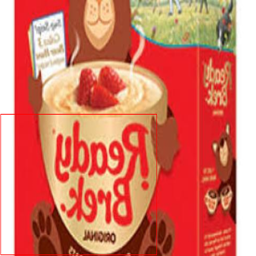

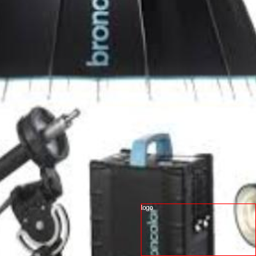

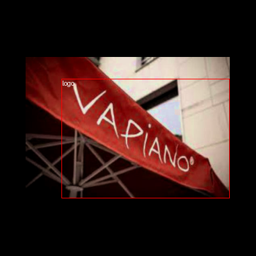

In [ ]:
# Process images for indices [15, 16, 17]
for i in [15,16,17,200,21,4]:
    # Load image and annotations
    image = dataset["train"][i]["image_path"]
    annotations = dataset["train"][i]

    # Prepare bounding box and category
    bbox = annotations["bbox"]  # Single [x, y, w, h]
    category = [class_id]  # Single class ID for "logo"

    # Apply augmentation
    output = train_augmentation_and_transform(
        image=np.array(image),
        bboxes=[bbox],  # Wrap single bbox in a list
        category=category,
    )

    # Unpack augmented output
    aug_image = Image.fromarray(output["image"])
    aug_bboxes = output["bboxes"]
    aug_categories = output["category"]

    # Draw augmented image with bounding box
    draw = ImageDraw.Draw(aug_image)
    for category, box in zip(aug_categories, aug_bboxes):
        x, y, w, h = box
        draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
        draw.text((x, y), label, fill="white")  # Use "logo" as label

    # Display resized image
    display(aug_image.resize([256, 256]))

Reformatting annotations for a single example

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
import albumentations as A
from PIL import Image

class LogoDetDataset(Dataset):
    def __init__(self, dataset, image_processor, transform=None):
        self.dataset = dataset
        self.image_processor = image_processor
        self.transform = transform
        # Single class for logos
        self.class_id = 0  # Class ID for "logo"

    @staticmethod
    def format_image_annotations_as_coco(image_id, categories, boxes):
        """Format one set of image annotations to the COCO format

        Args:
            image_id (int): image id, e.g., 0, 1, 2, ...
            categories (List[int]): list of categories/class labels (all 0 for single-class logos)
            boxes (List[Tuple[float]]): list of bounding boxes in COCO format
                ([x, y, width, height] in absolute coordinates)

        Returns:
            dict: {
                "image_id": image id,
                "annotations": list of formatted annotations
            }
        """
        annotations = []
        for category, bbox in zip(categories, boxes):
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": list(bbox),
                "iscrowd": 0,
                "area": bbox[2] * bbox[3],
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        # Use numeric image_id (index) instead of string
        image_id = idx  # Use idx directly as a numeric ID
        image = sample["image_path"]  # Use 'image_path' from dataset
        bbox = sample["bbox"]  # Single [x, y, w, h]
        categories = [self.class_id]  # Single class ID for "logo"

        # Convert image to RGB numpy array
        image = np.array(image.convert("RGB"))

        # Apply augmentations
        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=[bbox],  # Wrap single bbox in list for albumentations
                category=categories,
            )
            image = transformed["image"]
            bboxes = transformed["bboxes"]
            categories = transformed["category"]
        else:
            bboxes = [bbox]  # Wrap in list if no transform applied

        # Format annotations in COCO format for image_processor
        formatted_annotations = self.format_image_annotations_as_coco(image_id, categories, bboxes)

        # Apply image processor transformations: resizing, rescaling, normalization
        result = self.image_processor(
            images=image, annotations=formatted_annotations, return_tensors="pt"
        )

        # Remove batch dimension added by image_processor
        result = {k: v[0] for k, v in result.items()}

        # Ensure image_id is a tensor
        result["image_id"] = torch.as_tensor([image_id], dtype=torch.int64)

        return result

Now we can combine the image and annotation transformations to use on a batch of examples

In [ ]:
train_dataset = LogoDetDataset(dataset["train"], image_processor, transform=train_augmentation_and_transform)
validation_dataset = LogoDetDataset(dataset["validation"], image_processor, transform=validation_transform)
test_dataset = LogoDetDataset(dataset["test"], image_processor, transform=validation_transform)

train_dataset[15]

{'pixel_values': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'labels': {'size': tensor([480, 480]), 'image_id': tensor([15]), 'class_labels': tensor([0]), 'boxes': tensor([[0.5000, 0.5025, 0.9962, 0.9899]]), 'area': tensor([227206.390

In [ ]:
test_dataset[0]

{'pixel_values': tensor([[[0.2431, 0.2431, 0.2431,  ..., 0.2431, 0.2431, 0.2431],
          [0.2431, 0.2431, 0.2431,  ..., 0.2431, 0.2431, 0.2431],
          [0.2431, 0.2431, 0.2431,  ..., 0.2431, 0.2431, 0.2431],
          ...,
          [0.2431, 0.2431, 0.2431,  ..., 0.2431, 0.2431, 0.2431],
          [0.2431, 0.2431, 0.2431,  ..., 0.2431, 0.2431, 0.2431],
          [0.2431, 0.2431, 0.2431,  ..., 0.2431, 0.2431, 0.2431]],
 
         [[0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          ...,
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020]],
 
         [[0.6353, 0.6353, 0.6353,  ..., 0.6353, 0.6353, 0.6353],
          [0.6353, 0.6353, 0.6353,  ..., 0.6353, 0.6353, 0.6353],
          [0.6353, 0.635

Image tensor shape: torch.Size([3, 480, 480])
[[0.50187624 0.5006203  0.6487524  0.48875943]]
Boxes shape: (1, 4)
Categories shape: (1,)


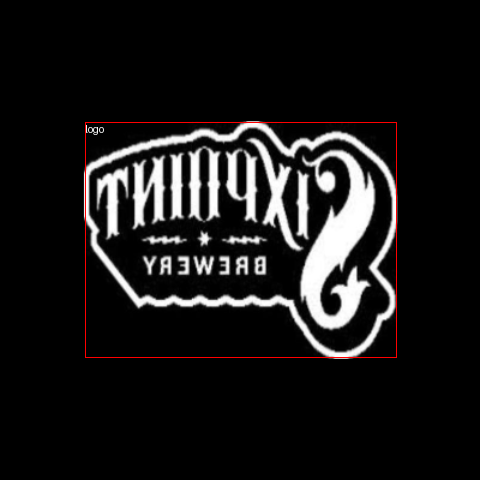

Image tensor shape: torch.Size([3, 480, 480])
[[0.36943907 0.36675826 0.6615087  0.5576923 ]]
Boxes shape: (1, 4)
Categories shape: (1,)


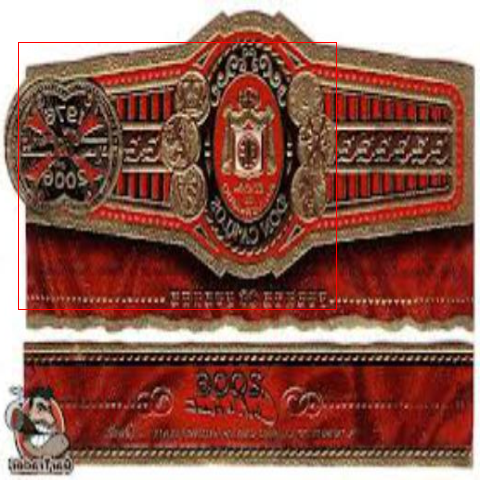

Image tensor shape: torch.Size([3, 480, 480])
[[0.6099453 0.5388448 0.7769844 0.7700291]]
Boxes shape: (1, 4)
Categories shape: (1,)


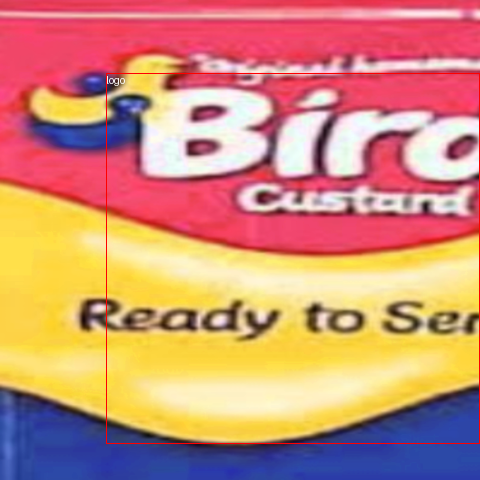

In [ ]:
# Define single-class label (no id2label needed)
label = "logo"

for i in [15, 16, 17]:
    sample = train_dataset[i]

    # De-normalize image
    image = sample["pixel_values"]
    print("Image tensor shape:", image.shape)
    image = image.numpy().transpose(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min()) * 255.
    image = Image.fromarray(image.astype(np.uint8))

    # Get bounding boxes and categories
    boxes = sample["labels"]["boxes"].numpy()
    print(boxes)
    print("Boxes shape:", boxes.shape)
    categories = sample["labels"]["class_labels"].numpy()
    print("Categories shape:", categories.shape)

    # Boxes are already in COCO format [x, y, w, h] from LogoDetDataset
    # Scale boxes to image dimensions
    boxes[:, :2] = boxes[:, :2] - boxes[:, 2:] / 2
    w, h = image.size
    boxes = boxes * np.array([w, h, w, h])[None]

    # Draw boxes and labels on image
    draw = ImageDraw.Draw(image)
    for box, category in zip(boxes, categories):
        x, y, w, h = box
        draw.rectangle([x, y, x + w, y + h], outline="red", width=1)
        draw.text((x, y), label, fill="white")  # Use "logo" as label

    display(image)

An example from the dataset after the transformations

In [ ]:
import torch

def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

a custom `collate_fn` to batch images together.

## Preparing function to compute mAP

`torchmetrics` to compute `mAP` (mean average precision) and `mAR` (mean average recall) metrics and will wrap it to `compute_metrics` function in order to use in Trainer for evalutation

In [ ]:
import numpy as np
from dataclasses import dataclass
from transformers.image_transforms import center_to_corners_format
from torchmetrics.detection.mean_ap import MeanAveragePrecision


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, size in zip(target_batch, image_size_batch):

                # here we have "yolo" format (x_center, y_center, width, height) in relative coordinates 0..1
                # and we need to convert it to "pascal" format (x_min, y_min, x_max, y_max) in absolute coordinates
                height, width = size
                boxes = torch.tensor(target["boxes"])
                boxes = center_to_corners_format(boxes)
                boxes = boxes * torch.tensor([[width, height, width, height]])

                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=image_processor, threshold=0.01, id2label=id2label)

## Training the detection model

Load the model

In [ ]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r18vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([1]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([1]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([1]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
- model.denoi

Defining the training hyperparameters

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="rtdetr-v2-r50-logo-finetune",
    num_train_epochs=2,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=4,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    report_to="tensorboard",  # or "wandb"
)

Training with trainer.train()

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=validation_dataset,
    eval_dataset=test_dataset,
    processing_class=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 5575 has 14.74 GiB memory in use. Of the allocated memory 14.43 GiB is allocated by PyTorch, and 174.60 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Evaluate

In [ ]:
from pprint import pprint

metrics = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="eval")
pprint(metrics)

## Inference

In [ ]:
import torch
import requests
from PIL import Image, ImageDraw

device = "cuda"

# url = "https://images.pexels.com/photos/8413299/pexels-photo-8413299.jpeg?auto=compress&cs=tinysrgb&w=630&h=375&dpr=2"
# image = Image.open(requests.get(url, stream=True).raw)

image = Image.open("/content/SCR-20250528-jvug-2.jpeg")

Load model and image processor

In [ ]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection

model_repo = "/content/rtdetr-v2-r50-logo-finetune"

image_processor = AutoImageProcessor.from_pretrained(model_repo)
model = AutoModelForObjectDetection.from_pretrained(model_repo)
model = model.to(device)

And detect bounding boxes:

In [ ]:
inputs = image_processor(images=[image], return_tensors="pt")
inputs = inputs.to(device)
with torch.no_grad():
    outputs = model(**inputs)
target_sizes = torch.tensor([image.size[::-1]])

result = image_processor.post_process_object_detection(outputs, threshold=0.4, target_sizes=target_sizes)[0]

for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

plotting the result using supervision

In [ ]:
import torch
import supervision as sv
detections = sv.Detections.from_transformers(
    transformers_results=result,
    id2label=model.config.id2label)

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)

In [ ]:
labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]


annotated_frame = label_annotator.annotate(
    scene=image.copy(),
    detections=detections,
    labels=labels
)
annotated_frame = box_annotator.annotate(
    scene=annotated_frame.copy(),
    detections=detections
)

In [ ]:
annotated_frame

In [ ]:
image_with_boxes = image.copy()
draw = ImageDraw.Draw(image_with_boxes)

for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    text_label = model.config.id2label[label.item()]
    draw.text((x, y), f"{text_label} [ {score.item():.2f} ]", fill="blue")

image_with_boxes